In [1]:
import sys
import os
sys.path.append(os.path.abspath('../..'))
import datetime
import concurrent.futures
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import threading



In [2]:

from utlis.sync_utlis.sync_df_utlis import find_calib_file
from utlis.scan_engine_utlis.scan_engine_utlis import (
    read_failed_paths,
    match_date_pattern,
    assign_status_codes,
)
from scan_engine.status_fields_config import STATUS_FIELDS_CONFIG

# Import functions from utils.py
from utlis.scan_engine_utlis.scan_log_utlis import (
    load_scan_log,
    save_scan_log,
    clean_scan_log,
    update_scan_log,
    get_folders_to_scan
)

def scan_folder(folder_name, base_folder, failed_paths, config, rec_files_to_scan):
    folder_path = os.path.join(base_folder, folder_name)
    rec_files_data = []  # To store rec files and their status
    calib_files = []  # To store calibration files

    # Check for calibration files starting with 'calib'
    for file_name in os.listdir(folder_path):
        if file_name.startswith("calib"):
            calib_files.append(file_name)

    # Traverse subfolders within this folder
    for subfolder_name in rec_files_to_scan:
        subfolder_path = os.path.join(folder_path, subfolder_name)

        # Check for subfolders starting with a digit (rec folders)
        if os.path.isdir(subfolder_path) and subfolder_name[0].isdigit():
            # Find calibration file for each subfolder
            calib_file = find_calib_file(subfolder_path)

            # Assign status codes dynamically based on the config
            rec_file_data = assign_status_codes(
                folder_name, subfolder_path, calib_file, failed_paths, config
            )

            rec_file_data['rec_file'] = subfolder_name  # Add rec_file to the data
            # Add date-time for update and some future
            rec_file_data['scan_time'] = datetime.datetime.now().isoformat()

            rec_files_data.append(rec_file_data)

    return {
        'date_folder': folder_name,
        'calib_files': calib_files,  # Store the calibration files under date_folder level
        'rec_files_data': rec_files_data  # Each rec file with its status fields
    }

def log_folder_to_parquet_sep(base_folder, failed_paths_file, config, force_rescan_rec_files=None, rescan_threshold_days=7):
    """Log folders and save Parquet in subfolders with partial scan support."""

    # Paths for scan log
    scan_log_path = os.path.join(base_folder, 'paret', 'scan_log.csv')

    # Load or initialize the scan log
    scan_log_df = load_scan_log(scan_log_path)

    # Read manually inputted failed paths
    failed_paths = read_failed_paths(failed_paths_file) if failed_paths_file else set()

    # Forced rescans
    # force_rescan_rec_files = [
    #     # ('2023-10-01', '001'),
    #     # ('2023-10-02', '002'),
    #     # Add more as needed
    # ]
    # force_rescan_rec_files_set = set(force_rescan_rec_files)
    
    if force_rescan_rec_files is None:
        force_rescan_rec_files = []
    force_rescan_rec_files_set = set(force_rescan_rec_files)



    # Rescan threshold
    # rescan_threshold_days = 7

    # Determine folders to scan
    folders_to_scan = get_folders_to_scan(base_folder, scan_log_df, rescan_threshold_days, force_rescan_rec_files_set)

    if not folders_to_scan:
        print("No new or modified folders to scan.")
        return

    # Use ThreadPoolExecutor for parallel folder scanning
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for date_folder, rec_files_to_scan in folders_to_scan.items():
            futures.append(
                executor.submit(
                    scan_folder,
                    date_folder,
                    base_folder,
                    failed_paths,
                    config,
                    rec_files_to_scan
                )
            )

        for future in concurrent.futures.as_completed(futures):
            folder_log = future.result()
            date_folder = folder_log['date_folder']
            calib_files = folder_log.get('calib_files', [])

            # Ensure 'calib_files' is always a list of strings
            calib_files = [str(f) for f in calib_files] if calib_files else []

            # Process and save each experiment's log separately
            for rec_file_data in folder_log['rec_files_data']:
                rec_file = rec_file_data['rec_file']
                subfolder_save_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

                # Ensure the experiment/rec_file folder exists
                os.makedirs(os.path.dirname(subfolder_save_path), exist_ok=True)

                # Add 'date_folder' and 'calib_files' to rec_file_data
                rec_file_data['date_folder'] = date_folder
                rec_file_data['calib_files'] = calib_files

                # Dynamically ensure all relevant columns are strings based on config
                status_columns = list(config.keys())
                df = pd.DataFrame([rec_file_data])
                df[status_columns] = df[status_columns].astype(str)

                # Convert the data into a DataFrame and save the Parquet file
                table = pa.Table.from_pandas(df)
                pq.write_table(table, subfolder_save_path)

                print(f"Log for {rec_file} saved at {subfolder_save_path}")

                # Update the scan log
                scan_log_df = update_scan_log(scan_log_df, date_folder, rec_file)

    # Clean up the scan log
    scan_log_df = clean_scan_log(scan_log_df, base_folder)

    # Save the updated scan log
    save_scan_log(scan_log_df, scan_log_path)

if __name__ == "__main__":
    base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"  # Replace with your base folder
    # save_path = os.path.join(base_folder, 'paret')
    failed_paths_file = '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/mir_bundle_run/synced_folders/240914_failed_sum_test.txt'  # File containing failed paths


    force_rescan_rec_files = [
        # ('2023-10-01', '001'),
        # ('2023-10-02', '002'),
        # Add more as needed
    ]
    rescan_threshold_days = 0.01 # 7 days, but guess if i mess up i can just change it to automatically rescan all, smile... #0.1

    log_folder_to_parquet_sep(base_folder, failed_paths_file, STATUS_FIELDS_CONFIG,
                              force_rescan_rec_files=force_rescan_rec_files,
                              rescan_threshold_days=rescan_threshold_days)


No new or modified folders to scan.


In [3]:
sys.path.append(os.path.abspath('../..'))
from utlis.scan_engine_utlis.scan_engine_utlis import read_all_parquet_files
base_folder = "/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ"
all_df = read_all_parquet_files(base_folder)

In [4]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '0'),
    pc.not_equal(table['sync'], '3')
)

# Apply the filter and print the results
filtered_table = table.filter(filter_mask)

# Print each row of the filtered table
print(filtered_table.to_pandas())  # This will display the filtered data in a familiar pandas-like format


Empty DataFrame
Columns: [mir_generate_param, sync, rec_file, scan_time, date_folder, calib_files]
Index: []


In [7]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.exe_engine_utlis.mir_generate_param_modu import mir_generate_param_z

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder)
    calib_path = rec_file_data['calib_path'] if 'calib_path' in rec_file_data else os.path.join(combined_path, 'calib_before') #calib_before*
    calib_path = os.path.join(base_folder, date_folder, calib_path)
    if not calib_path:  # Check for empty or None calib_path
        print(f'No calib folder found. Aborting. {combined_path}/{rec_file}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'

    # Call your processing function
    ssssta = mir_generate_param_z(combined_path, calib_path, rec_file, output_file)
    print("mir_generate_param ran successfully.")

    # After processing, update the status in the specific Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    # Load the existing Parquet file
    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()  # Convert to pandas for easier manipulation
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return

    if ssssta is True:
        # Update the status field (assuming 'sync' is the column)
        df['mir_generate_param'] = '1'  # Set status to '1' for processed

        # Add scan_time (or other updates)
        df['scan_time'] = datetime.datetime.now().isoformat()

        # Write the updated DataFrame back to the Parquet file
        updated_table = pa.Table.from_pandas(df)
        pq.write_table(updated_table, parquet_file_path)

        print(f"Updated Parquet file at {parquet_file_path} with new status.")
    else:
        print(f'processed failed. please check {combined_path}/{rec_file}')

# Function to handle sequential processing and status updates
def sequential_process_and_update(filtered_table, base_folder):
    # Convert PyArrow table to pandas DataFrame
    filtered_df = filtered_table.to_pandas()

    # Process each row sequentially
    for row in filtered_df.itertuples(index=False):
        try:
            process_unit_and_update_status(row._asdict(), base_folder)
        except Exception as e:
            print(f"Error in processing: {e}")

# Example function call
# filtered_table = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


Found 6 calibration files.
Frame count: 54300
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam1_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam2_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam3_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam4_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam5_params.mat
Processed /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/calib_before/hires_cam6_params.mat
Data saved to /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min/2024_10_07_20240916v1r1_15_05_30min_calib_before_label3d_dannce.mat
mir_generate_param ran successfully.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min/folder_log.parquet 

In [5]:
import pyarrow.compute as pc
table = all_df #combined_df
# Filter mir_generate_param == 0 and sync != 3
filter_mask = pc.and_(
    pc.equal(table['mir_generate_param'], '1'),
    # pc.not_equal(table['sync'], '3'),
    pc.equal(table['sync'], '0')
)

# Apply the filter and print the results
filtered_table_for_sync = table.filter(filter_mask) # seems that one can just be here. other wise filter mask or something.

# Print each row of the filtered table
print(filtered_table_for_sync.to_pandas())  # This will display the filtered data in a familiar pandas-like format

Empty DataFrame
Columns: [mir_generate_param, sync, rec_file, scan_time, date_folder, calib_files]
Index: []


Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2


[mov,mp4,m4a,3gp,3g2,mj2 @ 0x5559eade6900] moov atom not found


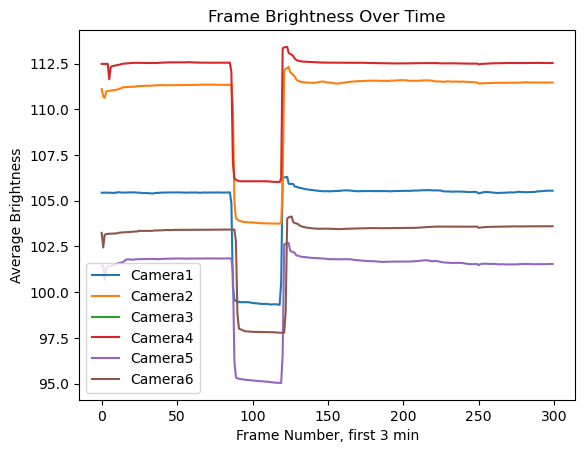

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2: {'Camera1': [87], 'Camera2': [88], 'Camera3': [], 'Camera4': [87], 'Camera5': [88], 'Camera6': [90]}
Skipping process_calibration_data for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2 due to missing drop frames
please mannually process /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2
Failed processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2, status set to 3.
Updated Parquet file at /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_08_26/20240730_PMCr2/folder_log.parquet with new status.
Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2


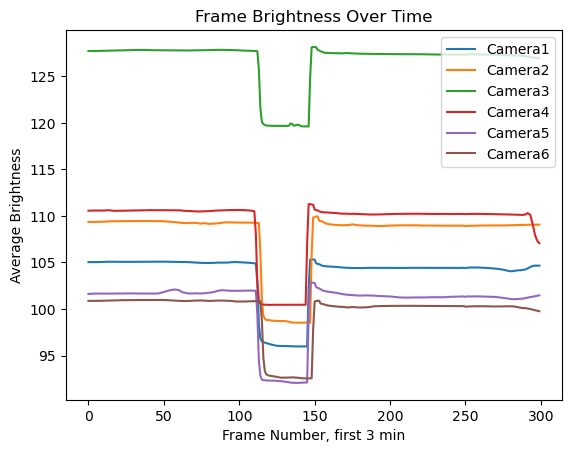

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2: {'Camera1': [112, 113], 'Camera2': [114, 115], 'Camera3': [114], 'Camera4': [111, 112], 'Camera5': [112, 113], 'Camera6': [115, 116]}
Processed drop frames: {'Camera1': 113, 'Camera2': 115, 'Camera3': 114, 'Camera4': 112, 'Camera5': 113, 'Camera6': 116}
112
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2/df_synced_20240819-V1-r2_calib_before_13_17_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2
Error during alignment: Destination path '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2/prev_calib/calib_before_13_17_label3d_dannce.mat' already exists
please mannually process /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2
Failed processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_09_18/20240819-V1-r2, s

In [10]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import process_sync

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file sequentially
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder, rec_file)
    calib_path = rec_file_data.get('calib_path', os.path.join(base_folder, 'calib_before'))
    
    if not calib_path:
        print(f'No calib folder found. Aborting. {combined_path}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
    print(f"Processing: {combined_path}")
    
    # Call the sync processing function
    sync_status = process_sync(combined_path, threshold=2, max_frames=300)
    if sync_status is True:
        print("Sync ran successfully.")
    else:
        print(f"please mannually process {combined_path}")

    # Update the status in the Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return
    
    # status = '1' if sync_status else '3'
    status = '3' if not sync_status else '1'
    if status == '3':
        print(f"Failed processing: {combined_path}, status set to 3.")
    
    # Update status and scan_time
    df['sync'] = status
    df['scan_time'] = datetime.datetime.now().isoformat()

    # Write back to the Parquet file
    updated_table = pa.Table.from_pandas(df)
    pq.write_table(updated_table, parquet_file_path)
    print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
# Sequentially process and update the status for each rec_file
def sequential_process_and_update(filtered_table, base_folder):
    filtered_df = filtered_table.to_pandas()
    
    for _, row in filtered_df.iterrows():
        process_unit_and_update_status(row.to_dict(), base_folder)

# Example function call
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table_for_sync, base_folder)


Processing: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min


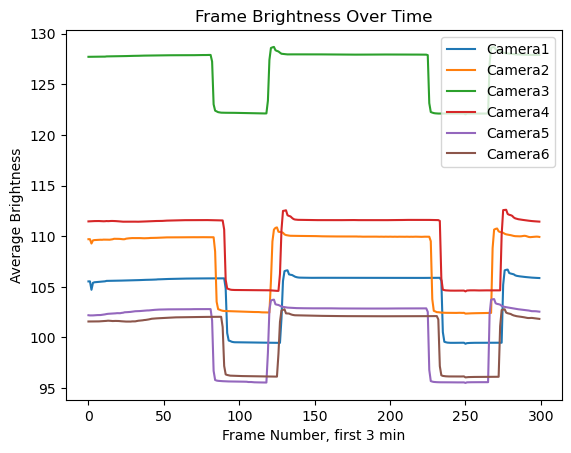

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min: {'Camera1': [92, 235], 'Camera2': [85, 228], 'Camera3': [83, 226], 'Camera4': [91, 234], 'Camera5': [83, 226], 'Camera6': [90, 233]}
Processed drop frames: {'Camera1': 92, 'Camera2': 85, 'Camera3': 83, 'Camera4': 91, 'Camera5': 83, 'Camera6': 90}
83
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min/df_synced_20240916v1r1_15_05_30min_2024_10_07_20240916v1r1_15_05_30min_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min
Error during alignment: Destination path '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_15_05_30min/prev_calib/2024_10_07_20240916v1r1_15_05_30min_calib_before_label3d_dannce.mat' already exists
please mannually process /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916

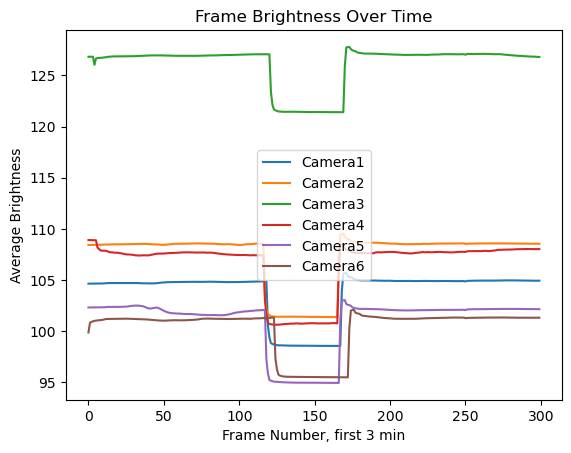

Detected intensity drop frames in /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_17_55: {'Camera1': [119], 'Camera2': [117], 'Camera3': [121], 'Camera4': [117], 'Camera5': [118], 'Camera6': [124]}
Processed drop frames: {'Camera1': 119, 'Camera2': 117, 'Camera3': 121, 'Camera4': 117, 'Camera5': 118, 'Camera6': 124}
117
alined data saved to: /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_17_55/df_synced_20240916v1r1_17_55_2024_10_07_20240916v1r1_17_55_calib_before_label3d_dannce.mat
Alignment successful for /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_17_55
Error during alignment: Destination path '/hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_17_55/prev_calib/2024_10_07_20240916v1r1_17_55_calib_before_label3d_dannce.mat' already exists
please mannually process /hpc/group/tdunn/Bryan_Rigs/BigOpenField/24summ/2024_10_07/20240916v1r1_17_55
Failed processing: /hpc/group/tdunn/Bryan_Rigs/B

In [9]:
import os
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
import datetime
import sys
sys.path.append(os.path.abspath('../..'))
from utlis.sync_utlis.sync_df_utlis import process_sync

# Function to process each "unit" (rec_file) and update its status in the corresponding Parquet file sequentially
def process_unit_and_update_status(rec_file_data, base_folder):
    date_folder = rec_file_data['date_folder']
    rec_file = rec_file_data['rec_file']
    
    # Generate the paths needed for processing
    combined_path = os.path.join(base_folder, date_folder, rec_file)
    calib_path = rec_file_data.get('calib_path', os.path.join(base_folder, 'calib_before'))
    
    if not calib_path:
        print(f'No calib folder found. Aborting. {combined_path}')
        return
    
    output_file = f'{os.path.basename(date_folder)}_{rec_file}_{os.path.basename(calib_path)}_label3d_dannce.mat'
    print(f"Processing: {combined_path}")
    
    # Call the sync processing function
    sync_status = process_sync(combined_path, threshold=2, max_frames=300)
    if sync_status is True:
        print("Sync ran successfully.")
    else:
        print(f"please mannually process {combined_path}")

    # Update the status in the Parquet file
    parquet_file_path = os.path.join(base_folder, date_folder, rec_file, "folder_log.parquet")

    try:
        table = pq.read_table(parquet_file_path)
        df = table.to_pandas()
    except FileNotFoundError:
        print(f"Parquet file not found at {parquet_file_path}")
        return
    
    # status = '1' if sync_status else '3'
    status = '3' if not sync_status else '1'
    if status == '3':
        print(f"Failed processing: {combined_path}, status set to 3.")
    
    # Update status and scan_time
    df['sync'] = status
    df['scan_time'] = datetime.datetime.now().isoformat()

    # Write back to the Parquet file
    updated_table = pa.Table.from_pandas(df)
    pq.write_table(updated_table, parquet_file_path)
    print(f"Updated Parquet file at {parquet_file_path} with new status.")
   
# Sequentially process and update the status for each rec_file
def sequential_process_and_update(filtered_table, base_folder):
    filtered_df = filtered_table.to_pandas()
    
    for _, row in filtered_df.iterrows():
        process_unit_and_update_status(row.to_dict(), base_folder)

# Example function call
# filtered_table_for_sync = [...]  # Your filtered PyArrow table here
# base_folder = '/path/to/your/base_folder'
sequential_process_and_update(filtered_table, base_folder)


In [ ]:
# if sync fail, this is used to delete all synced files...
# import os
# import concurrent.futures

# # Function to delete all files ending with '_label3d_dannce.mat' in the specified folder
# def delete_label3d_files_in_folder(rec_file_data, base_folder):
#     date_folder = rec_file_data['date_folder']
#     rec_file = rec_file_data['rec_file']
    
#     # Generate the combined path
#     combined_path = os.path.join(base_folder, date_folder, rec_file)
    
#     # Check if the folder exists
#     if not os.path.exists(combined_path):
#         print(f"Folder not found: {combined_path}")
#         return
    
#     # Find and delete all files ending with '_label3d_dannce.mat'
#     for file_name in os.listdir(combined_path):
#         if file_name.endswith('_label3d_dannce.mat'):
#             file_path = os.path.join(combined_path, file_name)
#             os.remove(file_path)
#             print(f"Deleted file: {file_path}")

# # Function to handle parallel deletion using filtered_table
# def parallel_delete_label3d_files(filtered_table, base_folder):
#     # Convert PyArrow table to pandas DataFrame
#     filtered_df = filtered_table.to_pandas()

#     with concurrent.futures.ThreadPoolExecutor() as executor:
#         futures = [
#             executor.submit(delete_label3d_files_in_folder, row._asdict(), base_folder)
#             for row in filtered_df.itertuples(index=False)
#         ]
        
#         for future in concurrent.futures.as_completed(futures):
#             try:
#                 future.result()  # Handle any exceptions
#             except Exception as e:
#                 print(f"Error during deletion: {e}")

# # Example function call
# # filtered_table = [...]  # Your filtered PyArrow table here
# # base_folder = '/path/to/your/base_folder'
# parallel_delete_label3d_files(filtered_table_for_sync, base_folder)
